In [1]:
# Import libraries
import urllib.request
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

2024-12-03 19:36:33.540898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 19:36:33.561434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 19:36:33.567801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 19:36:33.583339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 19:36:34.406391: W tensorflow/compiler/tf2

In [2]:
# Load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Data shape:', X_train.shape)

Data shape: (60000, 28, 28)


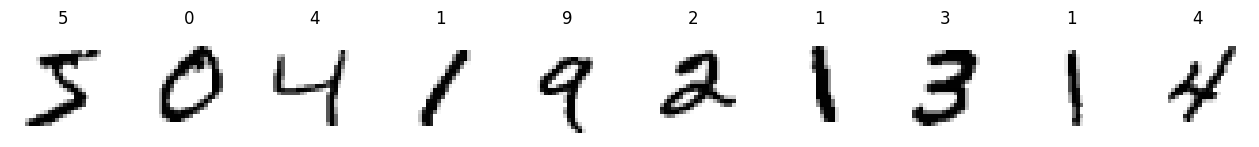

In [3]:
# Show images and labels
def show_images(images, labels):
    images_cnt = len(images)
    assert images_cnt <= 10, f"Number of images cannot exceed 10. The provided list has {images_cnt} elements."
    assert images_cnt == len(labels), f"Number of images ({images_cnt}) should be equal to number of labels ({len(labels)})"
    f, axarr = plt.subplots(nrows=1, ncols=images_cnt, figsize=(16,16))
    for idx in range(images_cnt):
        img = images[idx]
        lab = labels[idx]
        axarr[idx].imshow(img, cmap='gray_r')
        axarr[idx].title.set_text(lab)
        axarr[idx].axis('off')

    plt.show()   
    
show_images(X_train[:10], y_train[:10])

In [4]:
# Define the layers in the model
inputs = Input(shape=(28, 28, 1))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=64, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
flat = Flatten()(pool1)
dense1 = Dense(1024, activation='relu')(flat)
dropout1 = Dropout(0.5)(dense1)
outputs = Dense(10, activation='softmax')(dropout1)

# Define the model with inputs and outputs
model = Model(inputs, outputs)

2024-12-03 19:36:57.135512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


In [5]:
# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [6]:
# Prepare Azure ML Job
from azureml.core import Workspace, Experiment

# Create an instance of the Workspace class using the subscription information
ws = Workspace(
    subscription_id="4146a64a-b6f1-4f69-86c4-c662a18fda06",
    resource_group="vakanski-rg",
    workspace_name="My_workspace_2",
)

# Create an Azure ML experiment within the workspace "ws"
experiment = Experiment(ws, "demo-mnist_training")

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=5)

Epoch 1/5


I0000 00:00:1733254689.236624    4141 service.cc:146] XLA service 0x7f003c005bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733254689.236652    4141 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-03 19:38:09.263542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 19:38:09.396759: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  42/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5000 - loss: 49.1273  

I0000 00:00:1733254691.161159    4141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8556 - loss: 4.2539
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9214 - loss: 0.3819
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9220 - loss: 0.3726
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9189 - loss: 0.3941
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9283 - loss: 0.3491


In [8]:
# Save the model
model.save('mnist-tf-model.h5')

In [9]:
# Register the model
from azureml.core.model import Model

registered_model = Model.register(
    workspace=ws,
    model_name='mnist-tf-model',
    model_path='mnist-tf-model.h5',
    model_framework=Model.Framework.TENSORFLOW,
    model_framework_version=tf.__version__)

Registering model mnist-tf-model


In [10]:
# load the registered model
aml_model = Model(workspace=ws, name='mnist-tf-model', version=registered_model.version)

downloaded_model_filename = aml_model.download(exist_ok=True)

downloaded_model = tf.keras.models.load_model(downloaded_model_filename)

In [11]:
# Evaluate the model
downloaded_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9492 - loss: 0.2576


[0.21805879473686218, 0.9577999711036682]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


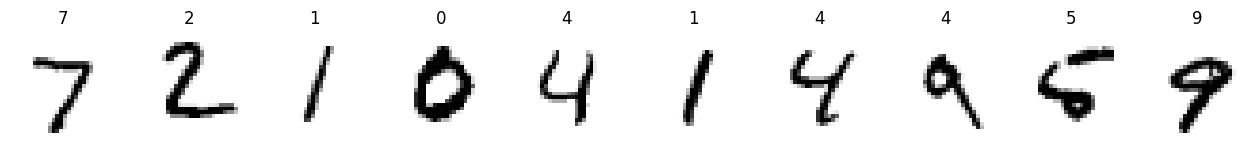

In [12]:
# Predict the labels of test images
preds = downloaded_model.predict(X_test).argmax(axis=1)

show_images(X_test[:10], preds[:10])